# VIOLENT CRIME ANALYSIS 

## INTRODUCTION

Violent crime spans a wide spectrum of offences, from simple assault and robbery to murder. 

Since the Corona virus affects the respiratory organs in our body, Many countries adapted the lockdown rule where people were asked to stay in, not to leave their homes often, to control the spread of the virus. The United Kingdome (UK) gross domestic product (GDP) – a measure of total economic activity – fell by 24% between February and April 2020, with the first national lockdown announced in late March. (Galvão, 2020)

Violent crime encompasses a wide range of offences, from common assault and robbery to murders. They are generally considered to be offences of violence against a person or persons and can include the use of weapons such a knives, firearms, and corrosive substances like acid. There was a rise in people's dissatisfaction and anxiety, which related to domestic violence (Card and Dahl, 2011); and alcohol abuse (Angelucci, 2008)

### AIM:

The objective of this report is to work on the given datasets, confirming if domestic violence compounded due to lockdowns and whether the outcome of it had consequences to the increase in crime rates.

### FINDINGS:

Working on the six subquestions will help in achieving the solution to the main objective.

There are datasets available in the blackboard, of which we consider all crimes to analyse the violent crimes and LSOA_pop to work on the last question, analysis for a particular region.

The all crimes dataset is a huge dataset of over 2.3GiB and inorder to import and work with it, a blob storage has been created. 

The data is available from 2010-2021. But one of the categories **"Violent Crime"** was last found in **2012** and **"Violent and sexual offences" was found from 2013** onwards. Hence, we will be considering the latter to work on solving the questions.

A brief overview of what has been done here:
<ol>
    <li>Dataframe</li>
    <li>Pandas</li>
    <li>Decomposition & Plotting</li>
    <li>Pandas</li>
    <li>Time series: Stationary</li>
    <li>ADF Test</li>
    <li>Detrending + Differencing</li>
    <li>SARIMAX</li>
 </ol>
    

In [1]:
#importing the all necessary packages
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore") # Ignoring warnings
import itertools

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import * 

import statsmodels.api as sm

Creating a spark session. Finding out whether the spark context displays the UI version and the Application name.

In [2]:
spark = SparkSession.builder.appName("Python Spark App").getOrCreate()

#Check Spark Contextme
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Python Spark App>

*%%time* command is used to display the query execution time - Both CPU (User & system) in milli seconds and Wall Time in minutes and seconds.

The first dataset is taken into consideration - **all_crimes21_hdr.txt.gz**.
(Blob Storage in Azure is an object storage for storing large volumes of unstructured data)
Since the above file is over 2.3GiB, A blob storage has been created in the azure portal and the dataset has been loaded into, which is then retrieved using a dataframe.

Schema is a library for verifying Python data structures translated from JSON/YAML (or something else) to Python data-types, such as those retrieved through config-files, forms, external services, or command-line parsing.

In [3]:
%%time
myschema = StructType([StructField("Crime ID", StringType(), True),
StructField("Month", StringType(), True),
StructField("Reported by", StringType(), True),
StructField("Falls within", StringType(), True),
StructField("Longitude", DoubleType(), True),
StructField("Latitude", DoubleType(),True),
StructField("Location", StringType(),True),
StructField("LSOA code", StringType(),True),
StructField("LSOA name", StringType(),True),
StructField("Crime type", StringType(),True),
StructField("Last outcome category", StringType(),True),
StructField("Context", StringType(),True)])

url = "https://sreeshastorageaccount.blob.core.windows.net/sreeshdatacrime/all_crimes21_hdr.txt.gz"
spark.sparkContext.addFile(url)


CPU times: user 15.4 ms, sys: 10.7 ms, total: 26.1 ms
Wall time: 1min 18s


A DataFrame is a two-dimensional named data structure with several forms of columns. 

dataframe1 is created with the use of myschema and the read.csv command has been used to read the CSV file.

In [4]:
dframe1 = spark.read.csv("file://" + SparkFiles.get("all_crimes21_hdr.txt.gz"), header=True, schema= myschema)

**Question #1:** What crime categories does the Police data use?

To address this question, the different groups under the Crime Type must be determined from the entire crimes dataset. 

<ul> <li>The COUNT function is used to check the amount of values in a number field that is part of a range or array. </li>
<li> The SQL phrase GROUP BY is used to group rows with the same values. </li> </ul>

In [5]:
Crime_categories = dframe1.groupby("Crime Type").count()
Crime_categories.show(truncate=0)

+----------------------------+--------+
|Crime Type                  |count   |
+----------------------------+--------+
|Bicycle theft               |735689  |
|Public order                |2564695 |
|Drugs                       |1682486 |
|Public disorder and weapons |242145  |
|Other crime                 |2565111 |
|Robbery                     |696008  |
|Criminal damage and arson   |5343182 |
|Theft from the person       |714621  |
|Shoplifting                 |3227557 |
|Burglary                    |4350252 |
|Violent crime               |1673219 |
|Other theft                 |5206259 |
|Possession of weapons       |283189  |
|Violence and sexual offences|11411540|
|Vehicle crime               |4170769 |
|Anti-social behaviour       |20211528|
+----------------------------+--------+



*Ans1:* From the above output, there are **16** distinct categories under Crime Types in the crime data set. 
These categories include Robbery, Violent crime, Possession of weapons, Burglary and so on.

The count of Anti-social behaviour is the highest, followed by Violence and sexual offences.

**Question #2:** Have the same categories been used consistently?

A new dataframe has been created and using SQL queries, grouping by same types, aggregating by the Crime Type and ordering the obtained results by the year and month fetches us the desired output.

In [6]:
dframe2 = (dframe1.select("*")\
          .groupby("Month", "Crime Type")
          .agg(count("Crime Type").alias("CountNo"))
          .orderBy("Month", ascending = (True)))
dframe2.show(truncate=False)

+-------+---------------------+-------+
|Month  |Crime Type           |CountNo|
+-------+---------------------+-------+
|2010-12|Other crime          |142705 |
|2010-12|Vehicle crime        |29416  |
|2010-12|Anti-social behaviour|201016 |
|2010-12|Burglary             |37893  |
|2010-12|Robbery              |5731   |
|2010-12|Violent crime        |57580  |
|2011-01|Robbery              |6667   |
|2011-01|Vehicle crime        |34899  |
|2011-01|Burglary             |44388  |
|2011-01|Violent crime        |59823  |
|2011-01|Other crime          |167072 |
|2011-01|Anti-social behaviour|201792 |
|2011-02|Violent crime        |56691  |
|2011-02|Burglary             |41821  |
|2011-02|Robbery              |6480   |
|2011-02|Anti-social behaviour|206801 |
|2011-02|Vehicle crime        |33591  |
|2011-02|Other crime          |168945 |
|2011-03|Vehicle crime        |35174  |
|2011-03|Anti-social behaviour|241110 |
+-------+---------------------+-------+
only showing top 20 rows



*Ans2:* In 2010, Only 6 categories were used - Violent Crime, Anti-social behaviour, Vehicle crime, Burglary, Other crime and Robbery, which is similar in 2011 as well.
But towards the recent years, the count of categories has increased considerably.

In May 2013 (2013-15), the "Violent Crime" category got changed to "Violent and sexual offences". Though since 2013, the same revised name has been used (Violent and sexual offences) There has been change in the categories from the initial dataset in 2010 in comparison with the recent one in 2021 and it has not been the same. 

**Question #3:** Are levels of violent & sexual offences constant, increasing, or decreasing?

As mentioned earlier, the "Violent Crime" category modified into "Violent and sexual offences" post May'13, to answer this question, data from 2013-05 onwards has been considered. 

The "Violent and sexual offences" category has been filtered out and using pandas and time indexing, the values has been plotted in a graphical manner for easier understanding, from which the data decomposition is done.

In [7]:
#Filtering Violence and sexual offences from whole data
dframe3=(dframe1.select(dframe1.Month, dframe1['Crime type']).where(dframe1['Crime Type'] == 'Violence and sexual offences')\
    .groupby("Month", "Crime Type")
    .agg(count("Crime Type").alias("CountNo"))
    .orderBy("Month", ascending = True))

In [8]:
#Converting dataframe to pandas
pdfs = dframe3.toPandas()
#Converting the Pandas Dataframe to be TimeIndexed
pdfs.Month = pdfs.Month.astype('datetime64[ns]')
pdf1 = pdfs.set_index(pd.to_datetime(pdfs.Month))

pdframe2 = pdf1.loc['2014-01-01':]

Dataframe has been converted to Pandas. Pandas DF are used to manipulate numerical data and time series. datetime64 is a datetime functionality used here. to be changed to time Indexed value, for easier plotting using the x-axis, y-axis co-ordinates from which the conclusion can be arrived.

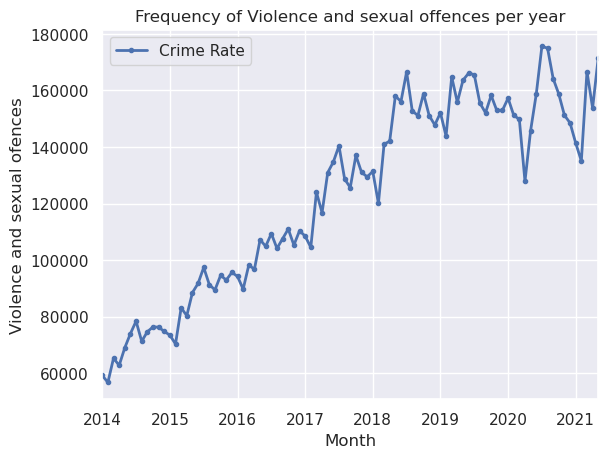

In [9]:
plt.figsize = (20, 9)
pdframe2.plot(y ='CountNo', x ='Month', marker='.', linestyle = '-', linewidth = 2,\
        label = 'Crime Rate',
        title = 'Frequency of Violence and sexual offences per year')
plt.ylabel('Violence and sexual ofences')
plt.show()

The value of Violence and sexual crime is plotted against every month, over a period of years from 2013 to 2021.
From the plot, Initially, the crime count seems to be under 80K upto the mid of 2014 post which the value dipped a bit until early 2015. Then there is a steady increase and a slight decrease of the values over the years. 

Though the lineplot maybe a linear trend, it is hard to be sure of it just by eye-balling. Hence, time series is used.

A time series is a collection of data points that appear in a logical sequence over a period of time. A time series is a set of well-defined data objects observed over time through repeated measurements.

An observed time series can be deconstructed into The trend (long-term direction: Upward or downward), the seasonal (systematic, calendar-related movements), and the residual/irregular(unsystematic, short term fluctuations) 

Decomposition is generally used for time series analysis and as an analysis tool. It offers a systematic approach to face a time series forecasting problem, both in terms of modelling complexity in general and in terms of how to best capture each of these components in a specific model.

Decomposition models are most commonly additive or multiplicative, although they can also be pseudo-additive. The decomposition plot obtained shows on basis of Trend, Seasonal and Residue.

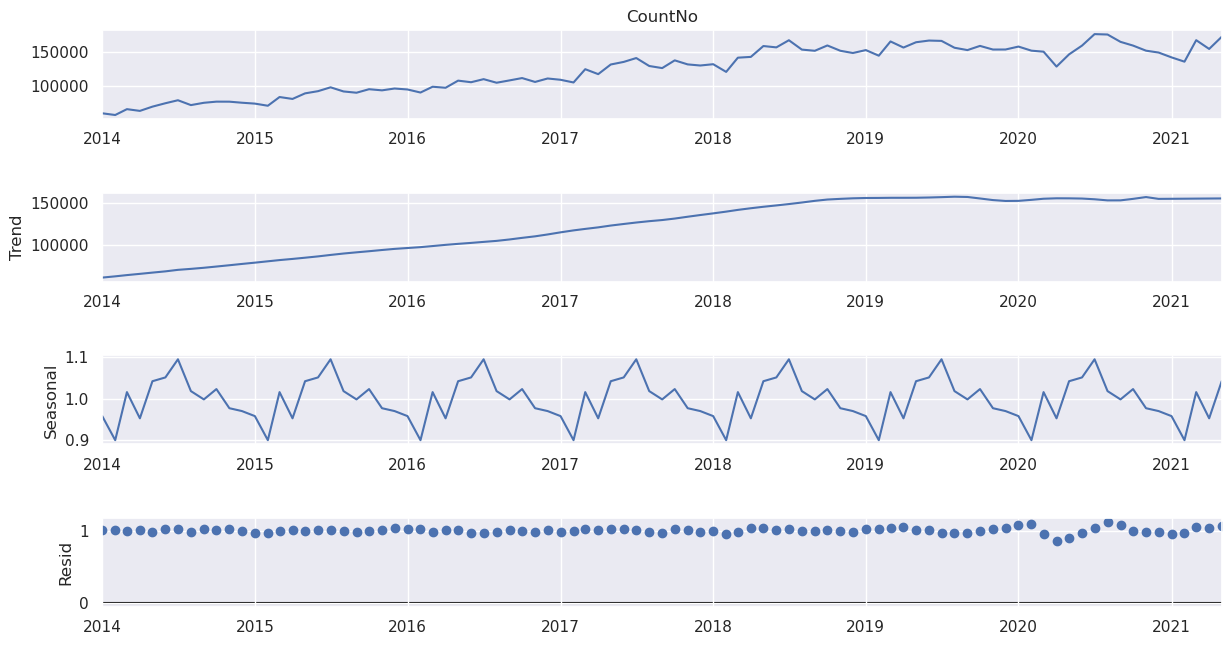

In [10]:
#Decomposition of data
decomposition = sm.tsa.seasonal_decompose(pdframe2['CountNo'], model='multiplicative',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

*Ans3:* From the above decomposition plot, the values or count increases steadily from mid 2013 upto 2020 after which the symmetry changes. 

During lockdown March 2020, a low count of recorded crimes was recorded after which it shoots up to a high value of almost 180 million, after which the count seem to decrease upto the start of 2021 and increases again.

If overall value is considered for violent crime analysis, since 2013, then the levels have been steadily increasing altogether.

But if the violent crime data during the pandemic (March 2020 to 2021) is taken into consideration, then the level is not considered constant as it keeps changing, decreases in the beginning, increases slowly, decreases again before increasing.

In [11]:
### plot for Rolling Statistic for testing Stationarity
pdframe3 = pdframe2[(pdframe2.Month.dt.year > 2012) ] 
def test_stationarity(timeseries, title):
    plt.clf()
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=4).mean() 
    rolstd = pd.Series(timeseries).rolling(window=4).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    plt.show()

Rolling Statistics is more of a visual technique in which the mean and standard deviation of the time series are plotted and checked if it varies with time. 

A stationary time series is one whose statistical properties such as mean, variance, autocorrelation are all constant over time.  Stationarizing a time series through differencing (where needed) is an important part of the process of fitting an ARIMA model

<Figure size 640x480 with 0 Axes>

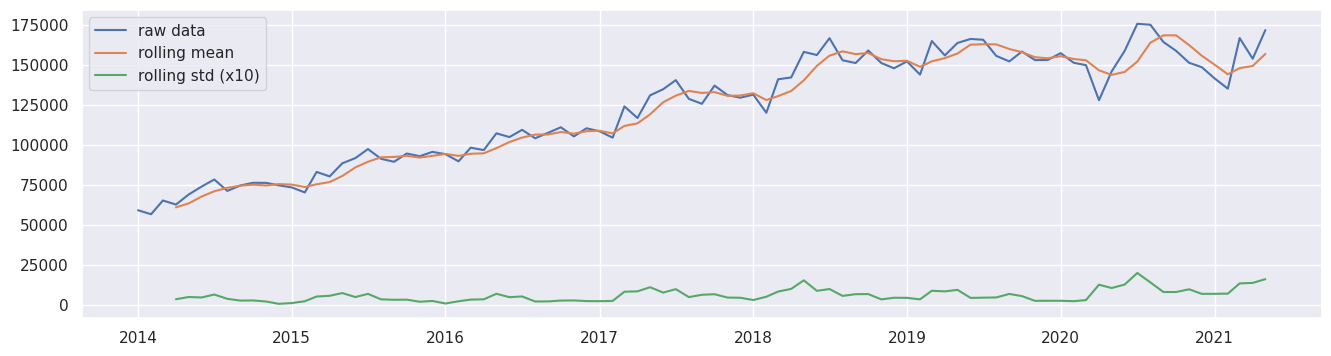

In [12]:
#Displaying the stationarity
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(pdframe3['CountNo'],'raw data')

ADF is a statistical test for checking stationarity. The more negative the statistic, the stronger the rejection of the hypothesis that htere is a unit root at some level of confidence. The ADF method is simply a statistical significance test in which the p-value is compared to the critical values and hypothesis testing is performed. With varying levels of confidence, we can decide if the processed data is stationary or not using this test.v

If p > 0.05, Null hypothesis stands True and Time series is not stationary.
If p <= 0.05, the null hypothesis is rejected and the Time series is stationary.

where 'p' is the order of the lag, or the difference between current and previous data.

In [13]:
# ADF Test -> Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def test_ADF(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [14]:
test_ADF(pdframe3['CountNo'],'raw data')

 > Is the raw data stationary ?
Test statistic = -1.769
P-value = 0.396
Critical values :
	1%: -3.5194805351545413 - The data is not stationary with 99% confidence
	5%: -2.9003945086747343 - The data is not stationary with 95% confidence
	10%: -2.5874984279778395 - The data is not stationary with 90% confidence


The raw data is checked for stationary. The 'p' value is over 0.05 hence it is a null hypothesis and the raw processed data is not stationary. Hence, other methods such as Detrending Differencing has been utilized to check if the data is stationary or not. The window size is set to 12.

<Figure size 640x480 with 0 Axes>

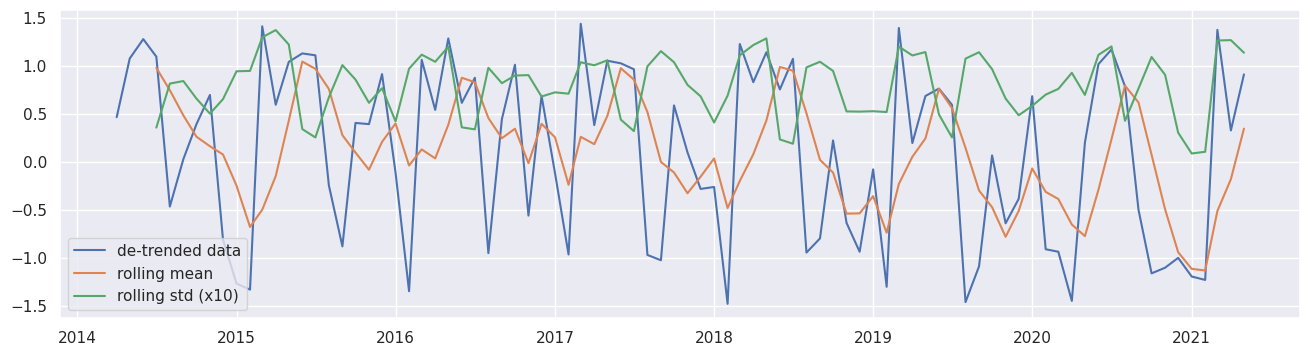

 > Is the de-trended data stationary ?
Test statistic = -1.069
P-value = 0.727
Critical values :
	1%: -3.5219803175527606 - The data is not stationary with 99% confidence
	5%: -2.9014701097664504 - The data is not stationary with 95% confidence
	10%: -2.58807215485756 - The data is not stationary with 90% confidence


In [15]:
# Detrending
y = pdframe3['CountNo']
y_detrend =  (y - y.rolling(window=4).mean())/y.rolling(window=4).std()

test_stationarity(y_detrend,'de-trended data')
test_ADF(y_detrend,'de-trended data')

The de-trended data is not taken into consideration. The 'p' value is over 0.05, similar to the result of raw data.
This is a null hypothesis and the data is not stationary. 

*Differencing:* compute the differences between consecutive observations, It can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality. (Kwiatkowski, 1992)

<Figure size 640x480 with 0 Axes>

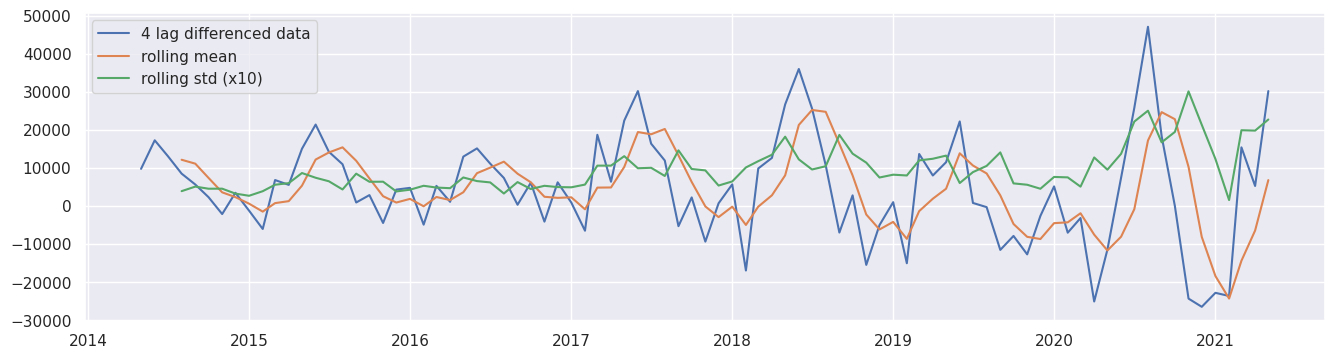

 > Is the 4 lag differenced data stationary ?
Test statistic = -1.266
P-value = 0.645
Critical values :
	1%: -3.524624466842421 - The data is not stationary with 99% confidence
	5%: -2.9026070739026064 - The data is not stationary with 95% confidence
	10%: -2.5886785262345677 - The data is not stationary with 90% confidence


In [16]:
# Differencing
y_4lag =  y - y.shift(4)

test_stationarity(y_4lag,'4 lag differenced data')
test_ADF(y_4lag,'4 lag differenced data')

In the Differencing method, the 12lag differenced data is plotted, where the 'p' value is over 0.05, This is a null hypothesis and the raw is not stationary. 

There are several methods to make data statistically stationary. Depending on the data, the trend elements can be removed, or the seasonal element, or a combination of both methods.

<Figure size 640x480 with 0 Axes>

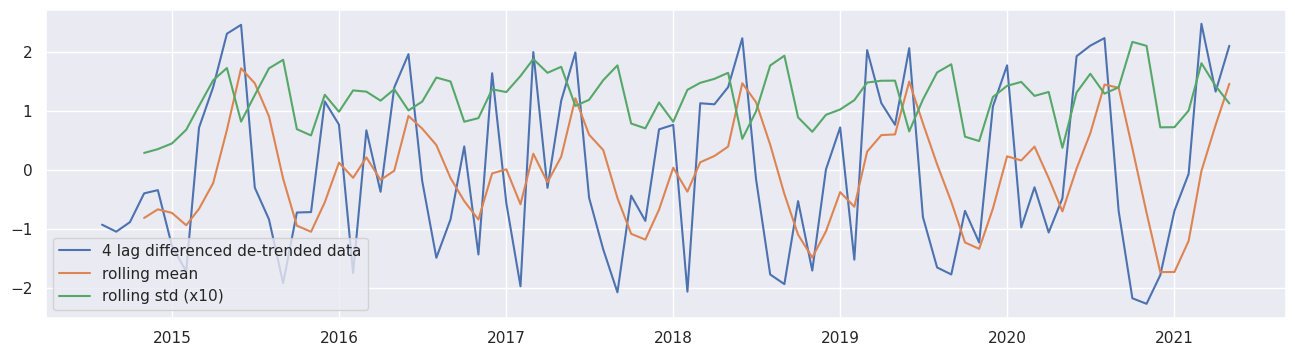

 > Is the 4 lag differenced de-trended data stationary ?
Test statistic = -5.299
P-value = 0.000
Critical values :
	1%: -3.5274258688046647 - The data is  stationary with 99% confidence
	5%: -2.903810816326531 - The data is  stationary with 95% confidence
	10%: -2.5893204081632653 - The data is  stationary with 90% confidence


In [17]:
# Detrending + Differencing

y_4lag_detrend =  y_detrend - y_detrend.shift(4)

test_stationarity(y_4lag_detrend,'4 lag differenced de-trended data')

test_ADF(y_4lag_detrend,'4 lag differenced de-trended data')

In [18]:
dediff_crime = y_4lag_detrend.dropna() # Dropping the NA

Upon combining the two methods - Detrending and Differencing, The 'p' value is less than 0.05 hence the null hypothesis is rejected and the time series is stationary. 

Now the considered data is stationary.

In [19]:
#Spliting the data into a training and test dataset
dediff_crime_to_train = dediff_crime[:'2020-03-01'] # dataset to train, Considering from before lockdown
dediff_crime_to_test = dediff_crime['2020-04-01': ] # test dataset, Considering after lockdown   
dediff_crime_to_val = dediff_crime_to_test

An autoregressive integrated moving average, or ARIMA, is a statistical analysis model that uses time series data to either better understand the data set or to predict future trends. A statistical model is autoregressive if it predicts future values based on past values.

The crucial thing is to choose the right forecasting method as per the characteristics of the time series data. ARIMA models provide another approach to time series forecasting. Exponential smoothing and ARIMA models are the two most widely used approaches to time series forecasting, and provide complementary approaches to the problem. 

the ARIMA model fits the training data slightly better 

Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors, or SARIMAX, is an extension of the ARIMA class of models or ARIMAX models with seasonal components.

p: refers to the number of autoregressive terms (lags of the stationarized series)
d: indicates the differencing that must be done to stationarize series
q: refers to the number of moving average terms (lags of the forecast errors)
s: indicates seasonal length in the data 

In [20]:
#Setting Grid Search Parameters for SARIMAX
#Generating the parameters List
warnings.filterwarnings("ignore") # specify to ignore warning messages
p = d = q = range(0, 2)
seasonal_period = 12
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]

In [21]:
#Carrying out the grid search
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =\
            sm.tsa.statespace.SARIMAX(dediff_crime_to_train,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as ex:
            print(ex)
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:233.23009932338272
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:207.5283283255465
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:140.46000856483985
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:131.40468442411375
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:177.32832685186474
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:171.56920466036573
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:132.01799242364746
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:133.08950188651608
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:231.23977390863848
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:205.21484495449786
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:142.06638589179613
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:133.0231957737223
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:177.02694043944484
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:172.28749375526615
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:133.89496584002427
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:134.8403625827656
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:259.4906195070522
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:233.36891017495

a Grid search was used to identify the best parameters.

A metric that can be used to compare the relative quality of each model is AIC (Akaike information criterion), which is an estimator of out-of-sample prediction error; a lower AIC score indicates a more predictive model.

In [22]:
# ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:128.46509985490266 - Lowest value

In [23]:
order = (1, 0, 1) #Using Values from the previous step
seasonal_order = (0, 1, 1, 12)
model = sm.tsa.statespace.SARIMAX(dediff_crime_to_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_invertibility=False)
results = model.fit()  #fitting the model

There are 4 plots obtained from the plot diagnostics results. 

By definition, the standardized residual is the residual divided by its standard deviation aand be useful in identifying the outliers.
The Histogram displays a normal distribution, mean can be calculated.
The Normal Q-Q graph shows a straight line, meaning the model's predictions are accurate.
A Correlogram shows the serial correlation in data that changes in time, that is used to check the randomness in the dataset.

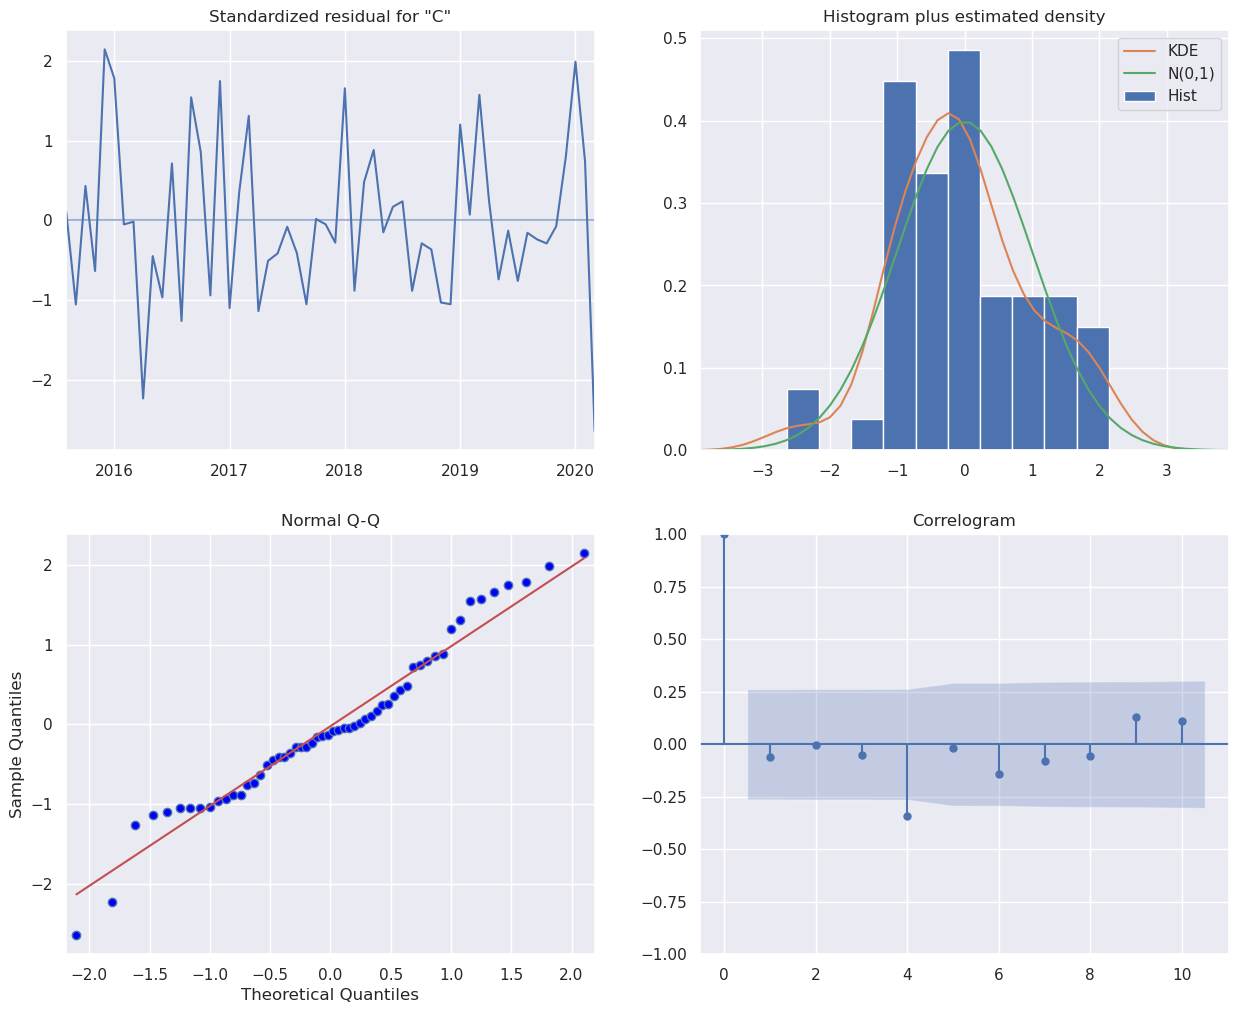

In [24]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

**Question #4:** Using data prior to the first lockdown predict Violence and sexual offences levels for April 2020

The observed and forecasted values are utilized in order to plot the Date versus CountNo graph.

In [25]:
pred_uc = results.get_forecast(steps=8)
pred_ci = pred_uc.conf_int()

*Ans4* From the plot, the Final table of predicted mean values, lower and upper band and the CountNo, the Violent crime levels for **April'20** can be predicted. 

It can be noticed that the actual value is much lesser than the forecasted value, meaning that in April '20, The forecast value was higher than the actual value.

But the value is not constant as it decreases after June, from July onwards, the actual value was way too higher than the predicted value to a certain point from which the value just increases.

The Violent crime value has not been constant consistently. April's predicted or forecasted value was more than the actual value, , on basis of the data prior to the first lockdown

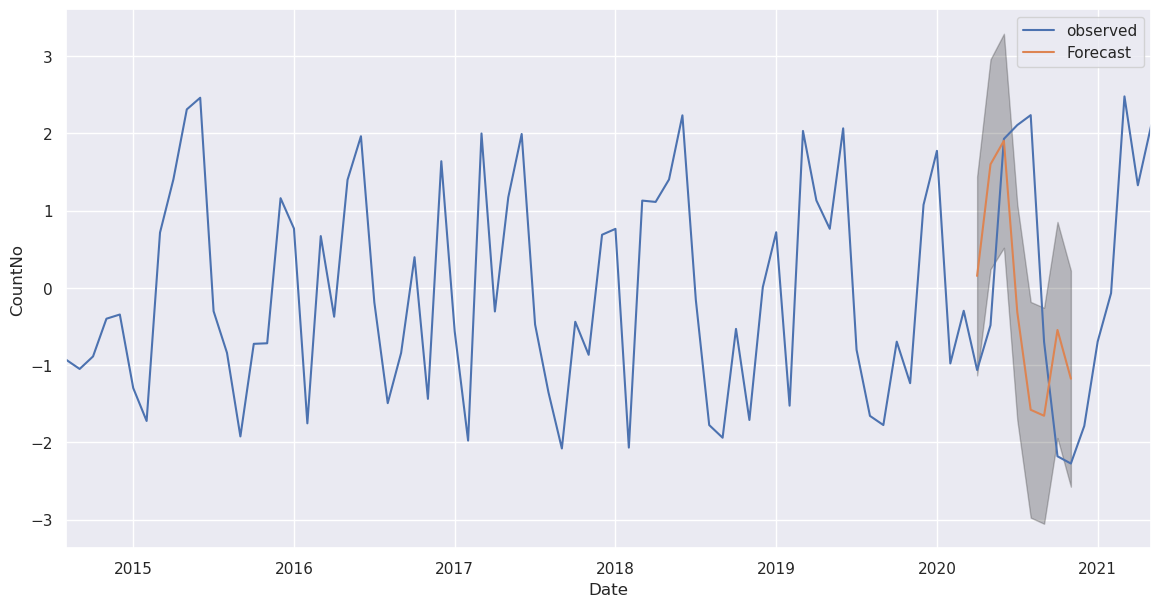

In [26]:
ax = dediff_crime.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CountNo')

plt.legend()
plt.show()

In [27]:
# Predicted mean
pm = pred_uc.predicted_mean.reset_index()
pm.columns = ['Date','Predicted_Mean']
pci = pred_ci.reset_index()
pci.columns = ['Date','Lower Bound','Upper Bound']

In [28]:
# Produce the forcasted tables 
final = pm.join(pci.set_index('Date'), on='Date')
final_table = final.merge(dediff_crime_to_test, left_on='Date', right_on='Month', how='inner')
final_table

,Date,Predicted_Mean,Lower Bound,Upper Bound,CountNo
0,2020-04-01,0.15460314,-1.13285488,1.44206116,-1.06348330
1,2020-05-01,1.60022827,0.24184862,2.95860792,-0.48326428
2,2020-06-01,1.90440769,0.51878636,3.29002901,1.92885744
3,2020-07-01,-0.31585205,-1.71189814,1.08019403,2.10788380
4,2020-08-01,-1.57839938,-2.97472584,-0.18207293,2.23630424
5,2020-09-01,-1.65572712,-3.05375992,-0.25769431,-0.70045777
6,2020-10-01,-0.54504099,-1.94375630,0.85367432,-2.18028703
7,2020-11-01,-1.17543077,-2.57441911,0.22355758,-2.27420748


**Question #5:** Compare predicted crime levels with actuals, and so determine whether significant changes to violent crime occurred

*Ans5:* From the above graph, the forecasted and observed plots are visible in orange and blue color respectively. The grey backgroud stands for lower and upper bound values.

For July, 2020-07 the forecasted value, the predicted mean is "179061" and the actual / observed mean value is "175562". 

After that, the next accurate value is in September, 2020-09 where the predicted mean value for forcast was "165399" while the actual value was "164204"

From the predicted crime value with actuals, there are changes in the violent crime involved. Initially for a few months, the forecasted value was higher than the actual value.

##### MODEL EVALUATION

In [29]:
###### RMSE - Root Mean Square Division

The root mean square error ***(RMSE)*** is the residuals' standard deviation (prediction errors). The residuals are a measure of how far away the data points are from the regression line; the RMSE is a measure of how spread out the residuals are.

In [30]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse(final_table['Predicted_Mean'], final_table['CountNo'])

1.9699496255721722

***MAE*** - The mean absolute error (MAE) is a metric for determining how close predictions are to actual results. The average of all absolute errors is the mean absolute error. In time series analysis, the mean absolute error is a typical metric of estimate error. An estimator's mean squared error is the average of the squares of the errors, or the difference between the estimator and the estimated.

In [31]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(final_table['CountNo'], final_table['Predicted_Mean'])

1.6567200398729551

From the values of the above evaluation techniques, the RMSE value and MAE values are over '1'
As RMSE value is scale-dependent, i.e. dependent on the dependent variable, it can not be claimed as a good value. The scaling factor is what makes sure that the values become proper.

 A high MAE means that the measurements from the device under test are very far in absolute value from the measurements from the reference instrument.

**Question #6:** The **Leicester** region was put in a local lockdown in July 2020. Verify your findings (if any) with respect to that region only?

Inorder to process this query, the next dataset is considered - **LSOA_pop_vs.csv**.
The csv file that is present in the blob storage is retrieved using a dataframe.

Then with the access of the first dataframe, the one with the all crime data, some queries are performed to obtain the Leicester region alone and the findings are plotted to get the desired result.

Again, *%%time* command is used to display the query execution time.

In [66]:
%%time
#adding the blob storage file to spark files.
url1 = "https://sreeshastorageaccount.blob.core.windows.net/sreeshdatacrime/LSOA_pop_v2.csv"
spark.sparkContext.addFile(url1)
#Loading the spark file data to Dataframes
dframe4 = spark.read.csv("file://" + SparkFiles.get("LSOA_pop_v2.csv"), header=True, inferSchema= True)

CPU times: user 14.2 ms, sys: 0 ns, total: 14.2 ms
Wall time: 464 ms


Using the previous dataframes1&4, all crimes data set and LSOA, SQL commands are performed in the below query to filter out the values and report for *July 2020.* in the *Leicester* region.

<ul> <li> JOIN command </li>
The LSOA code and geography code is compared and ones that equals, it picked up, along with the name of it.
    <li> FILTER command</li>
The month "July" as mentioned in the question and the region "Leicester" is selected.
    <li> GROUPBY command</li>  
The month and Crime Type categories or columns are considered.
    <li> AGGREGATE command</li>
The count of Crime Type is taken and the column name to display is set to "CountNo"
    <li> ORDERBY command</li>
The above values are ordered by the "Month" values, in ascending order.

In [67]:
dfss6 = dframe1.join(dframe4, ((dframe1['LSOA code'] == dframe4['geography code'])&(dframe1['LSOA name'] == dframe4.geography)))\
           .select(dframe1.Month, dframe1['Crime type'], dframe1['LSOA code'], dframe4.geography)\
           .where(dframe1['Crime Type'] == 'Violence and sexual offences')\
           .filter(dframe4.geography.contains("Leicester"))\
           .groupby("Month", "Crime Type")\
           .agg(count("Crime Type").alias("CountNo"))\
           .orderBy("Month", ascending = True)

In [68]:
#Converting dataframe to pandas
pdfs = dfss6.toPandas()
#Converting the Pandas Dataframe to be TimeIndexed
pdfs.Month = pdfs.Month.astype('datetime64[ns]')
Leicesterr = pdfs.set_index(pd.to_datetime(pdfs.Month))


Dataframe has been converted to Pandas. Pandas DF are used to manipulate numerical data and time series. *datetime64* is a datetime functionality used here. to be changed to time Indexed value, for easier plotting of Leicester region using the x-axis, y-axis co-ordinates from which the conclusion can be arrived.

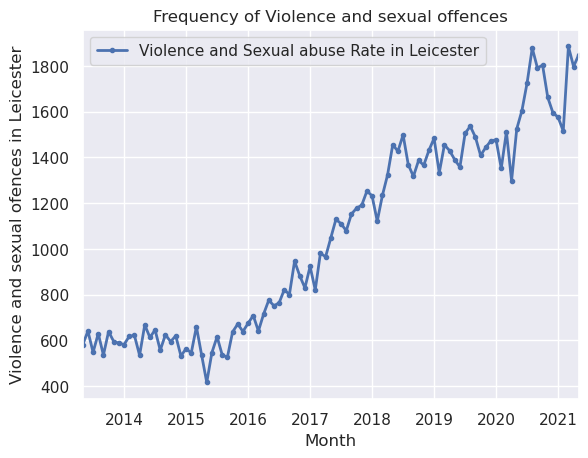

In [69]:
plt.figsize = (20, 9)
Leicesterr.plot(y ='CountNo', x ='Month', marker='.', linestyle = '-', linewidth = 2,\
        label = 'Violence and Sexual abuse Rate in Leicester',
        title = 'Frequency of Violence and sexual offences')
plt.ylabel('Violence and sexual ofences in Leicester')


From the above graph, it can be visualised that the Leister region findings are similar to that of the main violent analysis graph, where in the data count increases and decreases for a few months into 2020 and then gradually decreases, reaches peak in July and decreases upto the start of 2021 after which the value keeps changing.


The Violence and Sexual abuse rate in Leicester since July 2021

From the above graph, it is evident that the values are not constant all through the year, post July 2021. The crime rate increased decreased and increased February, after which it spiked up in March, decreased a little bit in April and increased again in May.

The reason why the count increased in August is that the lockdown restrictions changed and were lifted according to an announcement made on the 31st July 2020.

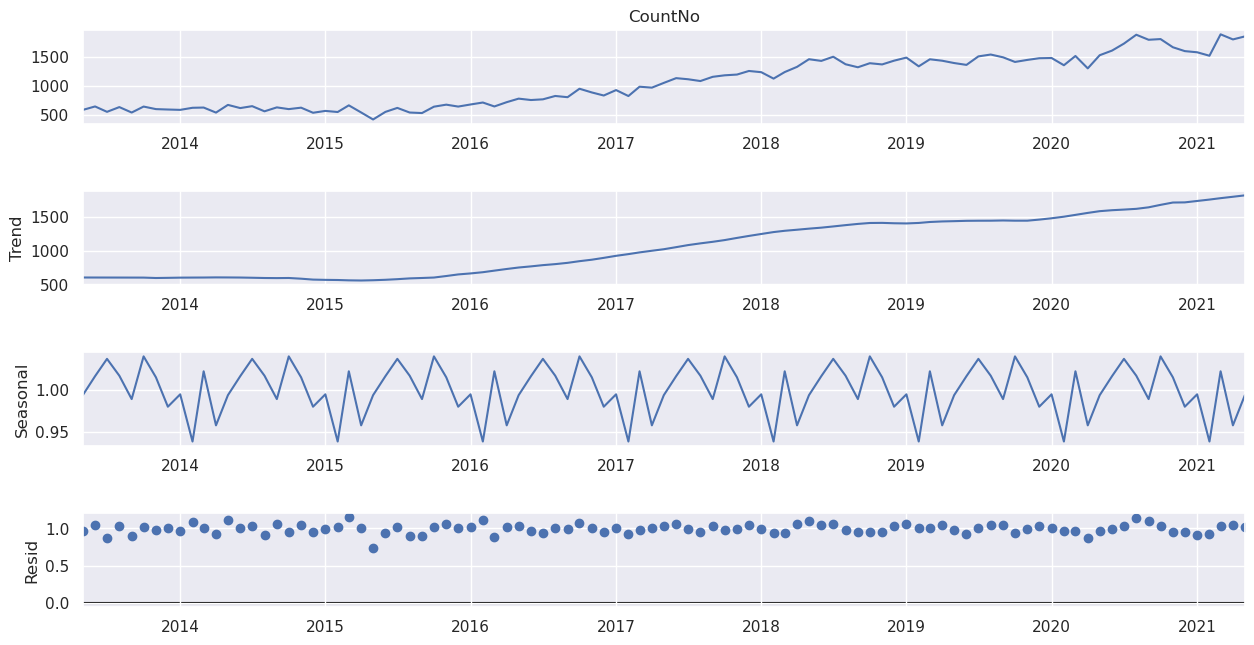

In [70]:
#Decomposition of data
decomposition = sm.tsa.seasonal_decompose(Leicesterr['CountNo'], model='multiplicative',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

In [71]:
### plot for Rolling Statistic for testing Stationarity - Leicester
Leicester_pdf3 = Leicesterr[(Leicesterr.Month.dt.year > 2012) ] 
def test_stationarity(timeseries, title):
    plt.clf()
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=4).mean() 
    rolstd = pd.Series(timeseries).rolling(window=4).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    plt.show()

<Figure size 640x480 with 0 Axes>

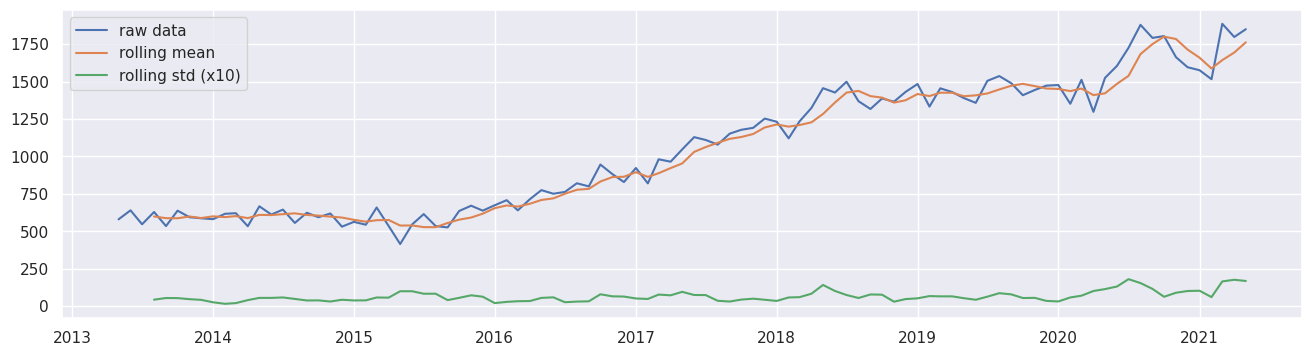

In [72]:
#Displaying the stationarity
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(Leicester_pdf3['CountNo'],'raw data')

In [73]:
test_ADF(Leicester_pdf3['CountNo'],'raw data')

 > Is the raw data stationary ?
Test statistic = 0.085
P-value = 0.965
Critical values :
	1%: -3.5011373281819504 - The data is not stationary with 99% confidence
	5%: -2.8924800524857854 - The data is not stationary with 95% confidence
	10%: -2.5832749307479226 - The data is not stationary with 90% confidence


The 'p' value is over 0.05 and the raw data value is not stationary.

<Figure size 640x480 with 0 Axes>

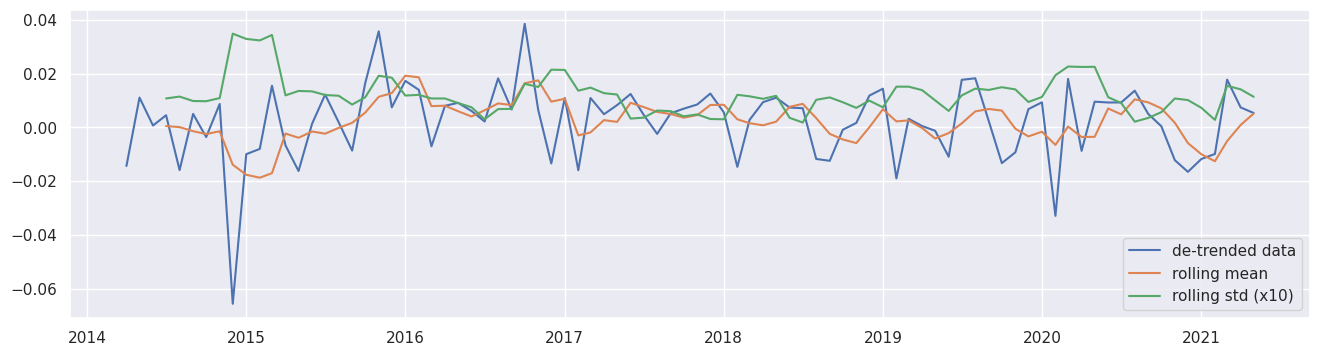

 > Is the de-trended data stationary ?
Test statistic = -8.643
P-value = 0.000
Critical values :
	1%: -3.5097356063504983 - The data is  stationary with 99% confidence
	5%: -2.8961947486260944 - The data is  stationary with 95% confidence
	10%: -2.5852576124567475 - The data is  stationary with 90% confidence


In [74]:
# Detrending
x = Leicester_pdf3['CountNo']
x_detrend =  (x - x.rolling(window=4).mean())/y.rolling(window=4).std()

test_stationarity(x_detrend,'de-trended data')
test_ADF(x_detrend,'de-trended data')

The de-trended data is taken into consideration. The 'p' value is less than 0.05, The data is stationary. Hence, this is taken for consideration.

In [75]:
x_detrend = x_detrend.dropna()

In [76]:
#Spliting the data into a training and test dataset
x_detrend_to_train = x_detrend[:'2020-06-01'] # dataset to train, Considering from before lockdown
x_detrend_to_test = x_detrend['2020-07-01': ] # test dataset, Considering after lockdown   
x_detrend_to_val = x_detrend_to_test

In [77]:
#Carrying out the grid search
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =\
            sm.tsa.statespace.SARIMAX(x_detrend_to_train,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as ex:
            print(ex)
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-419.77362177520376
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-418.85512055155283
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-326.2874730524827
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-335.0358079891142
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-419.173217956152
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-417.65449628549135
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-334.51274951949057
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-333.3917032439892
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:-417.8903221704951
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-417.15282171406113
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-327.92942849480755
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-335.3494092122018
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-417.5660688349796
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-416.1557474153319
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-335.1596419337564
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-333.80741081833827
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-365.72886700183346
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-367

In [ ]:
#ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-294.52445778194954 - Lowest AIX Value


Note: The AIC value can be negative or positive, the sign does not affect in the model prediction / calculation.

In [79]:
order = (0, 1, 0) #Using Values from the previous step
seasonal_order = (1, 1, 1, 12)
LeicesterModel = sm.tsa.statespace.SARIMAX(x_detrend_to_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_invertibility=False)
results = LeicesterModel.fit()  #fitting the model

There are 4 plots obtained from the plot diagnostics results. 

By definition, the standardized residual is the residual divided by its standard deviation aand be useful in identifying the outliers.
The Histogram displays a normal distribution, mean can be calculated.
The Normal Q-Q graph shows a straight line, meaning the model's predictions are accurate.
A Correlogram shows the serial correlation in data that changes in time, that is used to check the randomness in the dataset.

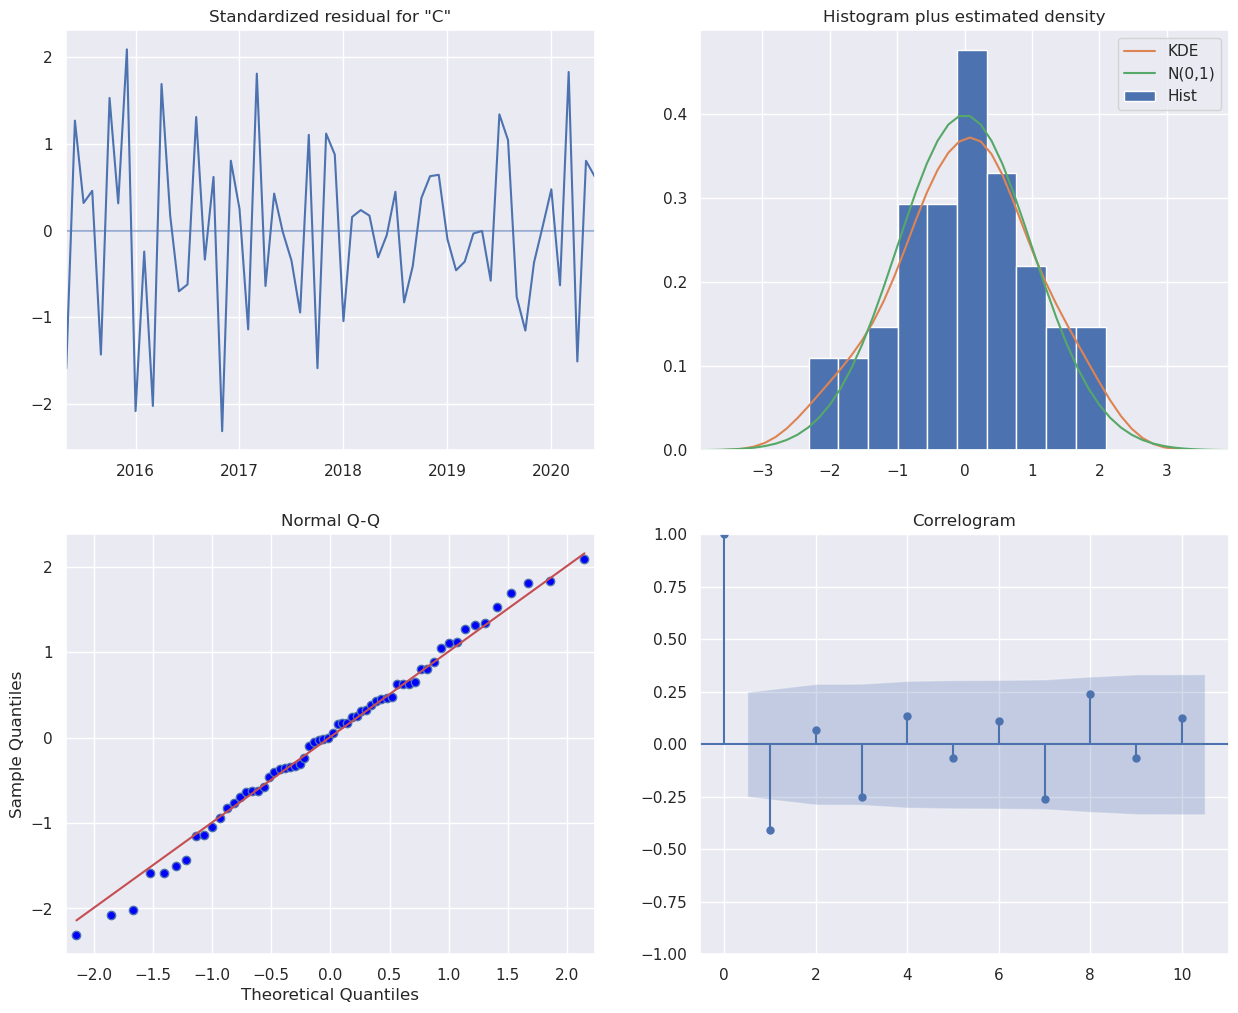

In [80]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [81]:
Leicesterpred_uc = results.get_forecast(steps=4)
Leicesterpred_ci = Leicesterpred_uc.conf_int()

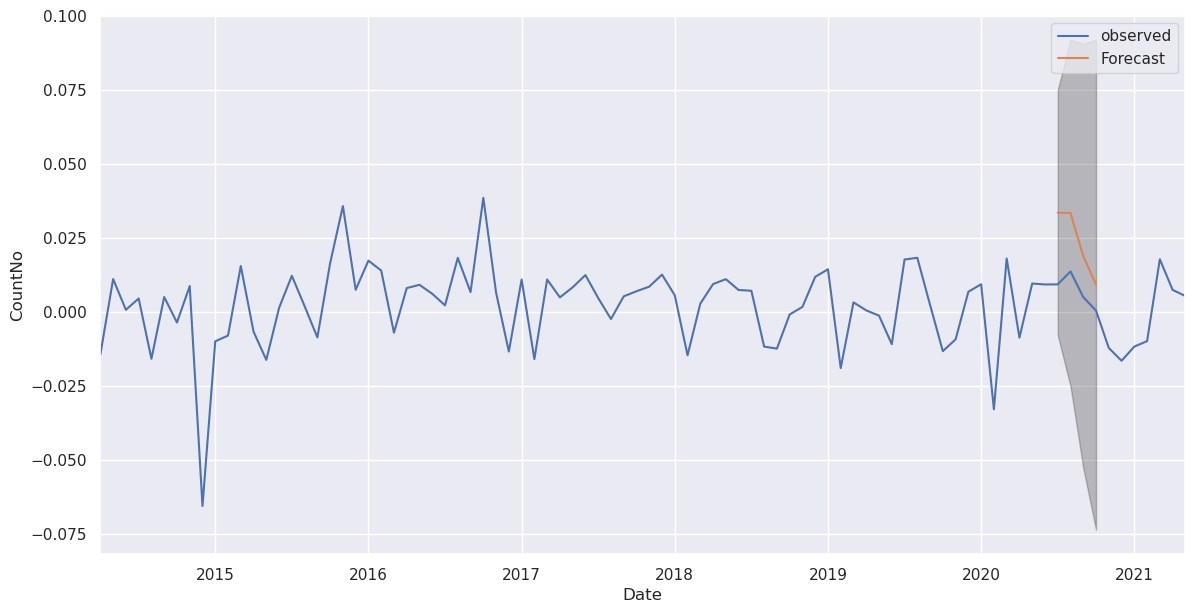

In [82]:
ax = x_detrend.plot(label='observed', figsize=(14, 7))
Leicesterpred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(Leicesterpred_ci.index,
                Leicesterpred_ci.iloc[:, 0],
                Leicesterpred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CountNo')

plt.legend()
plt.show()

From the graph, it is clear that the value keeps fluctuating from 2020-2021. Initially, the value decreased and then increased and the pattern kept on following upto the start of 2021. 

In July 2020 - Lockdown period, the predicted value was much higher than the actual value.

In [83]:
# Predicted Mean 
pmft = Leicesterpred_uc.predicted_mean.reset_index()
pmft.columns = ['Date','Predicted_Mean']
pcii = Leicesterpred_ci.reset_index()
pcii.columns = ['Date','Lower Bound','Upper Bound']
Leicesterfinal_table = pm.join(pci.set_index('Date'), on='Date')

In [84]:
# Produce the forcasted tables for 2020-07 onwards

Leicester_value = x_detrend.loc['2020-07':]


Leifinal = pmft.join(pci.set_index('Date'), on='Date')
Leicesterfinal_table = Leifinal.merge(x_detrend_to_test, left_on='Date', right_on='Month', how='inner')
Leicesterfinal_table

,Date,Predicted_Mean,Lower Bound,Upper Bound,CountNo
0,2020-07-01,0.03350382,-1.71189814,1.08019403,0.00930235
1,2020-08-01,0.03340693,-2.97472584,-0.18207293,0.01367021
2,2020-09-01,0.01888571,-3.05375992,-0.25769431,0.00500495
3,2020-10-01,0.00917163,-1.94375630,0.85367432,0.00045276


### RMSE for Leicester

In [85]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse(Leicesterfinal_table['Predicted_Mean'], Leicesterfinal_table['CountNo'])

0.01763479329759616

In [86]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Leicesterfinal_table['CountNo'], Leicesterfinal_table['Predicted_Mean'])

0.016634457740567547

RMSE & SME Values are a little over 0.01. This means that the model used for prediction is perfect since the value should be within the range from 0.0-0.5.

According to several authors (Ilesanmi et al., 2020, The Economist 2020, Piquero et al. 2021) lockdowns resulted in increased domestic violence, but did this result in an overall increase in recorded violent crime?

***
From the decomposition plot, it is clear that the values or count increases steadily from mid 2013 upto 2020 after which the symmetry changes. 

During lockdown March 2020, a low count of recorded crimes was recorded after which it shoots up to a high value of almost 180 million, after which the count seem to decrease upto the start of 2021 and increases again.

If overall value is considered for violent crime analysis, since 2013, then the levels have been steadily increasing altogether. But if the violent crime data during the pandemic (March 2020 to 2021) is taken into consideration, then the level is not considered constant as it keeps changing, decreases in the beginning, increases slowly, decreases again before increasing.

Using the timeseries, the forecast was done and compared with the actual values on the violence data and assumptions, models and evaluations were made accordingly.

Hence we can not come to a conclusion that the violent crime count increased during the pandemic in particular as the values kept on changing and was not a constant one. Increased for a while, then decreased.

***

###### References

* Angelucci, M. 2008. Love on the Rocks: Domestic Violence and Alcohol Abuse in Rural Mexico. B. E. Journal of Economic Analysis & Policy 8(1): 1- 43.nn

* Cook, E.R. and Kairiukstis, L.A. eds., 2013. *Methods of dendrochronology: applications in the environmental sciences.* Springer Science & Business Media.

* Friman, O., Borga, M., Lundberg, P. and Knutsson, H., 2004. Detection and detrending in fMRI data analysis. *NeuroImage*, 22(2), pp.645-655.

* Galvão, A.B. and Lopresto, M., 2020. Real-time Probabilistic Nowcasts of UK Quarterly GDP Growth using a Mixed-Frequency Bottom-up Approach. National Institute Economic Review, 254, pp.R1-R11.

* Kwiatkowski, D., Phillips, P.C., Schmidt, P. and Shin, Y., 1992. Testing the null hypothesis of stationarity against the alternative of a unit root: How sure are we that economic time series have a unit root?. Journal of econometrics, 54(1-3), pp.159-178.

* Mohapatra, R.N., Yugesh, S., Kalpana, G. and Kalaivani, C., *Mathematical Analysis and Computing.* (ICMAC 2019)

* Li, L., Su, X., Zhang, Y., Lin, Y. and Li, Z., 2015. *Trend modeling for traffic time series analysis: An integrated study. IEEE Transactions on Intelligent Transportation Systems, 16(6)*, pp.3430-3439.


Website Sources: 

* https://hansard.parliament.uk/Commons/2020-06-29/debates/0F09C0AB-4A72-4E67-832A-1F8FC07F2D2E/Covid-19Update
Accessed: 06th January 2021

* https://lordslibrary.parliament.uk/leicester-lockdown-changes-since-july-2020/ 
Accessed: 06th January 2021

* https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459
Accessed: 10th January 2021

* https://www.gov.uk/government/news/leicestershire-coronavirus-lockdown-areas-and-changes 
Accessed: 06th January 2021
